<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_MSFT_Rolling_Linear_submissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [54]:
pip install yfinance

In [55]:
pip install yahoofinancials

In [56]:
pip install pyfinance

In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# Data

In [58]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "MSFT",start=start,end=end,interval = "1d")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Next_close
248,2020-12-24,221.419998,223.610001,221.199997,222.750000,221.726166,10550600,224.960007
249,2020-12-28,224.449997,226.029999,223.020004,224.960007,223.925995,17933500,224.149994
250,2020-12-29,226.309998,227.179993,223.580002,224.149994,223.119720,17403200,221.679993
251,2020-12-30,225.229996,225.630005,221.470001,221.679993,220.661072,20272300,222.419998
252,2020-12-31,221.699997,223.000000,219.679993,222.419998,221.397675,20942100,NaN


In [59]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [60]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Date,,,,,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,158.205765,22622100,158.619995,160.619995,160.619995,0.0
2020-01-03,158.320007,159.949997,158.059998,158.619995,156.235825,21116200,159.029999,159.619995,160.419995,-21116200.0
2020-01-06,157.080002,159.100006,156.509995,159.029999,156.639694,20813700,157.580002,159.423330,160.280995,-302500.0
2020-01-07,159.320007,159.669998,157.320007,157.580002,155.211456,21634100,160.089996,158.409999,160.010896,-21936600.0
2020-01-08,158.929993,160.800003,157.949997,160.089996,157.683731,27746500,162.089996,158.899999,160.018806,5809900.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,221.419998,223.610001,221.199997,222.750000,221.726166,10550600,224.960007,222.570002,217.709132,645558400.0
2020-12-28,224.449997,226.029999,223.020004,224.960007,223.925995,17933500,224.149994,222.910004,218.434220,663491900.0
2020-12-29,226.309998,227.179993,223.580002,224.149994,223.119720,17403200,221.679993,223.953334,219.005797,646088700.0


In [61]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [62]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [63]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end subperiod           
19  0           0.268784
    1           0.266495
    2           0.240830
    3           0.243165
    4           0.266797
...                  ...
251 247         0.891535
    248         0.912340
    249         0.924560
    250         0.918067
    251         0.892392

[4660 rows x 1 columns]

In [64]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred = y_pred.drop(['end'], axis=1)
y_pred

,subperiod,predicted
0,0,0.268784
1,1,0.266432
2,2,0.244514
3,3,0.244415
4,4,0.271848
...,...,...
247,247,0.891439
248,248,0.913075
249,249,0.923873
250,250,0.913085


In [65]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.241089
1,1,0.245350
2,2,0.230282
3,3,0.256365
4,4,0.277148
...,...,...
247,247,0.907513
248,248,0.930479
249,249,0.922062
250,250,0.896394


In [66]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['MSFT_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,MSFT_RMSE_LIN
0,0.241089,0.268784,-0.027695,0.000767,0.027695
1,0.245350,0.266432,-0.021083,0.000444,0.021083
2,0.230282,0.244514,-0.014232,0.000203,0.014232
3,0.256365,0.244415,0.011950,0.000143,0.011950
4,0.277148,0.271848,0.005301,0.000028,0.005301
...,...,...,...,...,...
247,0.907513,0.891439,0.016074,0.000258,0.016074
248,0.930479,0.913075,0.017404,0.000303,0.017404
249,0.922062,0.923873,-0.001811,0.000003,0.001811
250,0.896394,0.913085,-0.016691,0.000279,0.016691


In [67]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.026848031537735226

## With sentiment

In [68]:
sent = pd.read_csv('MSFT_sentiment_submissions.csv')
sent = sent.rename(columns={'date':'Date'})
sent['Date'] = pd.to_datetime(sent['Date'])
df = pd.merge(df, sent, on = 'Date', how = 'left')
df = df.fillna(0)
df.describe()

,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,Unnamed: 0,compound,Count,average
count,253.000000,253.000000,2.530000e+02,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.000000,253.000000,253.000000,253.000000
mean,192.391265,193.026126,3.765959e+07,192.910237,195.465138,190.377431,192.781515,190.928454,3.014599e+08,131.936759,1.159558,8.280632,0.180726
std,25.924457,22.995562,1.690529e+07,23.102141,22.634497,23.283062,22.828625,21.885041,2.771189e+08,97.091901,2.698461,16.083744,0.354945
min,0.000000,135.419998,1.055060e+07,137.009995,140.570007,132.520004,138.680003,151.301839,-2.871756e+08,0.000000,-4.334800,0.000000,-0.709900
25%,174.380005,174.380005,2.617760e+07,174.199997,175.669998,170.910004,173.763331,170.678887,5.295610e+07,39.000000,0.000000,2.000000,0.000000
50%,201.910004,201.910004,3.279080e+07,200.419998,203.949997,197.740005,202.216665,196.730236,4.131433e+08,128.000000,0.585900,4.000000,0.082625
75%,212.830002,212.830002,4.387230e+07,213.100006,214.839996,210.309998,212.073334,211.842436,5.564404e+08,218.000000,1.834700,7.000000,0.397000
max,231.649994,231.649994,9.701270e+07,229.270004,232.860001,227.350006,228.149999,219.587895,6.875762e+08,303.000000,17.693100,134.000000,0.999500


In [69]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)

In [70]:
y_pred_sent = y_pred_sent.reset_index()
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [71]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})

In [72]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['MSFT_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])

In [73]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.025171779254648703

In [74]:
MSFT_linear = pd.merge(linear, linear_sent, on = 'actual')
MSFT_linear

,actual,predicted,difference,sq_er,MSFT_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,MSFT_RMSE_LIN_SENTIMENT
0,0.241089,0.268784,-0.027695,0.000767,0.027695,0,0,0.268456,-0.027367,0.000749,0.027367
1,0.245350,0.266432,-0.021083,0.000444,0.021083,1,21,0.265238,-0.019888,0.000396,0.019888
2,0.230282,0.244514,-0.014232,0.000203,0.014232,2,63,0.240429,-0.010147,0.000103,0.010147
3,0.256365,0.244415,0.011950,0.000143,0.011950,3,126,0.248143,0.008222,0.000068,0.008222
4,0.277148,0.271848,0.005301,0.000028,0.005301,4,210,0.270578,0.006571,0.000043,0.006571
...,...,...,...,...,...,...,...,...,...,...,...
257,0.907513,0.891439,0.016074,0.000258,0.016074,247,23085,0.891243,0.016270,0.000265,0.016270
258,0.930479,0.913075,0.017404,0.000303,0.017404,248,18510,0.912409,0.018070,0.000327,0.018070
259,0.922062,0.923873,-0.001811,0.000003,0.001811,249,13914,0.927004,-0.004942,0.000024,0.004942
260,0.896394,0.913085,-0.016691,0.000279,0.016691,250,9297,0.907862,-0.011468,0.000132,0.011468


In [75]:
MSFT_linear.describe()

,actual,predicted,difference,sq_er,MSFT_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,MSFT_RMSE_LIN_SENTIMENT
count,262.000000,262.000000,262.000000,2.620000e+02,262.000000,262.000000,262.000000,262.000000,262.000000,2.620000e+02,262.000000
mean,0.602601,0.602727,-0.000126,7.001407e-04,0.019921,125.698473,43290.725191,0.603487,-0.000886,6.216165e-04,0.018996
std,0.235936,0.233402,0.026511,1.114079e-03,0.017449,72.213954,26454.129660,0.234163,0.024964,9.515076e-04,0.016179
min,0.000000,0.043067,-0.081442,1.089920e-09,0.000033,0.000000,0.000000,0.032891,-0.070614,2.379712e-11,0.000005
25%,0.417074,0.416264,-0.015608,4.194737e-05,0.006475,64.250000,20490.000000,0.415463,-0.015004,4.317438e-05,0.006571
50%,0.693703,0.692356,0.000774,2.080118e-04,0.014423,126.500000,43390.000000,0.695126,-0.000877,2.096364e-04,0.014479
75%,0.803518,0.795547,0.013716,8.377736e-04,0.028941,187.750000,66290.000000,0.798816,0.014227,7.532879e-04,0.027446
max,1.000000,0.952607,0.073567,6.632744e-03,0.081442,251.000000,89190.000000,0.962232,0.065264,4.986367e-03,0.070614


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

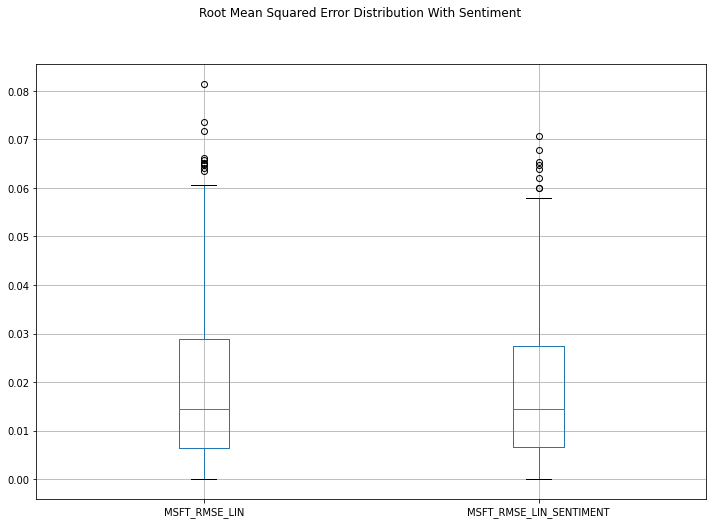

In [76]:
boxplot = MSFT_linear.boxplot(column=['MSFT_RMSE_LIN', 'MSFT_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [77]:
MSFT_linear_RMSE = MSFT_linear[['MSFT_RMSE_LIN', 'MSFT_RMSE_LIN_SENTIMENT']]
MSFT_linear_RMSE.describe()

,MSFT_RMSE_LIN,MSFT_RMSE_LIN_SENTIMENT
count,262.000000,262.000000
mean,0.019921,0.018996
std,0.017449,0.016179
min,0.000033,0.000005
25%,0.006475,0.006571
50%,0.014423,0.014479
75%,0.028941,0.027446
max,0.081442,0.070614


In [78]:
MSFT_linear_RMSE.to_csv('MSFT_Linear_Subs_Results.csv')